In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

from collections import defaultdict

from scipy.stats import mannwhitneyu

from sklearn.preprocessing import minmax_scale


import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

ro.r('library("hypeR")')
ro.r("source(paste(Sys.getenv('WSCL'),'diabetes_analysis/data_exploration/','helper_hypeR.R',sep=''))")
ro.r('library(pvclust)')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['pvclust', 'visNetwork', 'msigdbr', 'hypeR', 'tools', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U10')

In [3]:
path_rna='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/'
path_data=path_rna+'combined/'
path_de=path_rna+'de_human/diabetes/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'

In [4]:
path_de

'/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/de_human/diabetes/'

In [5]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [6]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')

## DE in human T1D/T2D
Perform DE betwee T1D/T2D and healthy donors (using all ages, sex, ...) on per-dataset basis. Find genes consistent across datasets.

In [126]:
# Do not test DE if either group has less than this many cells
min_cells=5
# Remove genes expressed in less than this ratio of cells
min_cells_ratio=0.1

In [21]:
# Compute OvR DE for markers
de_results=defaultdict(list)
for dataset,ddir in [('GSE83139','GSE83139/GEO/'),
                    ('GSE154126','GSE154126/GEO/'),
                    ('GSE101207','GSE101207/GEO/'),
                    ('GSE124742_GSE164875_patch','GSE124742_GSE164875/GEO/patch/'),
                    ('GSE124742_GSE164875_FACS','GSE124742_GSE164875/GEO/FACS/'),
                    ('GSE86469','GSE86469/GEO/'),
                    ('GSE81547','GSE81547/GEO/'),
                    ('GSE198623','P21000/sophie/human/'),
                    ('GSE81608','GSE81608/GEO/'),
                    ('GSE148073','GSE148073/GEO/')
                    ]:
    # Load adata
    print(dataset)
    adata_full=sc.read(path_rna+ddir+'adata_filtered.h5ad')
    for group in ['T1D','T2D']:
        print(group)
        # Subset to beta cells and disease phenotypes (removing pre pehnotypes and other diabetic)
        adata=adata_full[(adata_full.obs.cell_type=='beta').values& 
                    (adata_full.obs.disease.isin(['healthy',group])).values].copy()
        print(adata.shape)
        if 'gene_symbol' in adata.var.columns:
            adata.var_names=adata.var.gene_symbol

        # Only do DE if enough cells in each group
        cells_group=list(adata.obs.query('disease==@group').index)
        cells_rest=list(adata.obs.query('disease=="healthy"').index)
        print("N cells group %i and reference %i"%(len(cells_group),len(cells_rest)))
        if len(cells_group)>=min_cells and len(cells_rest)>=min_cells:

            # Remove genes expressed in less than N% cells in both groups individually
            ratio_group=np.asarray(
                (adata[cells_group,:].X>0).sum(axis=0)).ravel()/len(cells_group)
            mask_gene=np.logical_or(
                ratio_group>=min_cells_ratio,
                np.asarray(
                    (adata[cells_rest,:].X>0).sum(axis=0)).ravel()>=(len(cells_rest)*min_cells_ratio))
            # Subset data
            adata=adata[:,mask_gene].copy()

            # DE test
            key_added='rank_genes_'+group+'_vs_healthy'
            sc.tl.rank_genes_groups(adata, groupby='disease',
                                  use_raw=False, groups=[group], reference='healthy', 
                                  rankby_abs=True, method='t-test',
                                  key_added=key_added)

            de_res=pd.DataFrame({'gene_symbol':adata.uns[key_added]['names'][group],
                           'padj':adata.uns[key_added]['pvals_adj'][group],
                           'logFC':adata.uns[key_added]['logfoldchanges'][group]})
            # Add otehr info to results DF: 
            # dataset, n cells in each group, n cells in group expressing gene
            de_res['dataset']=dataset
            de_res['n_group']=len(cells_group)
            de_res['n_ref']=len(cells_rest)
            de_res['ratio_group']=ratio_group[mask_gene]
            display(de_res)
            de_results[group].append(de_res)
for group,data in de_results.items():
    de_results[group]=pd.concat(de_results[group])
    # Remove genes without gene symbol
    de_results[group]=de_results[group].query('gene_symbol!="nan"')
del adata
del adata_full

GSE83139
T1D
(73, 19950)
N cells group 6 and reference 67


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'BMI' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cultured_days' as categorical


,gene_symbol,padj,logFC,dataset,n_group,n_ref,ratio_group
0,CRP,2.653762e-04,5.404300,GSE83139,6,67,1.0
1,FXYD3,9.586213e-05,6.465961,GSE83139,6,67,1.0
2,ZNF91,2.759576e-12,-7.388538,GSE83139,6,67,1.0
3,TSIX,4.123457e-12,-8.402358,GSE83139,6,67,1.0
4,XIST,4.123457e-12,-8.673610,GSE83139,6,67,1.0
...,...,...,...,...,...,...,...
19945,PRMT10,9.999082e-01,-0.000536,GSE83139,6,67,1.0
19946,RAB6C,9.999082e-01,0.000208,GSE83139,6,67,1.0
19947,PTCHD2,9.999082e-01,0.000279,GSE83139,6,67,1.0
19948,RAB3IP,9.999486e-01,0.000250,GSE83139,6,67,1.0


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'BMI' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cultured_days' as categorical


T2D
(105, 19950)
N cells group 38 and reference 67


,gene_symbol,padj,logFC,dataset,n_group,n_ref,ratio_group
0,TRY6,1.087087e-10,-4.807086,GSE83139,38,67,1.0
1,PRSS1,1.087087e-10,-4.266847,GSE83139,38,67,1.0
2,CTRB2,2.541567e-08,-3.579158,GSE83139,38,67,1.0
3,REG1B,6.727300e-08,-4.399756,GSE83139,38,67,1.0
4,PRSS2,8.177571e-08,-3.875727,GSE83139,38,67,1.0
...,...,...,...,...,...,...,...
19945,CPNE2,9.995255e-01,0.000713,GSE83139,38,67,1.0
19946,RORA,9.995255e-01,0.000609,GSE83139,38,67,1.0
19947,MEG3,9.995255e-01,0.000457,GSE83139,38,67,1.0
19948,DZIP1L,9.997344e-01,0.000312,GSE83139,38,67,1.0


GSE154126
T1D
(136, 21152)
N cells group 0 and reference 136
T2D
(182, 21152)
N cells group 46 and reference 136


,gene_symbol,padj,logFC,dataset,n_group,n_ref,ratio_group
0,PRSS1,7.756017e-10,-3.384786,GSE154126,46,136,1.000000
1,PTGS2,3.597503e-09,-5.896740,GSE154126,46,136,1.000000
2,GP2,3.967590e-09,-28.783112,GSE154126,46,136,0.847826
3,CELA3A,3.967590e-09,-3.630498,GSE154126,46,136,1.000000
4,FABP5,1.185221e-08,-5.484361,GSE154126,46,136,0.543478
...,...,...,...,...,...,...,...
12564,LOC100132287,9.994773e-01,0.000652,GSE154126,46,136,0.108696
12565,ACVR2A,9.994773e-01,0.000630,GSE154126,46,136,0.130435
12566,TPR,9.996832e-01,-0.000263,GSE154126,46,136,0.021739
12567,KIAA0090,9.996832e-01,-0.000342,GSE154126,46,136,0.130435


GSE101207
T1D
(8092, 20485)
N cells group 0 and reference 8092
T2D
(9958, 20485)
N cells group 1866 and reference 8092


,gene_symbol,padj,logFC,dataset,n_group,n_ref,ratio_group
0,RBP4,2.442715e-213,-2.311511,GSE101207,1866,8092,0.228296
1,TTR,1.521682e-174,-1.531244,GSE101207,1866,8092,0.088424
2,INS,5.226939e-113,-0.671796,GSE101207,1866,8092,0.098607
3,RPL3,5.101244e-81,1.112430,GSE101207,1866,8092,0.074491
4,CPE,2.464465e-69,0.992015,GSE101207,1866,8092,0.133441
...,...,...,...,...,...,...,...
1600,SNX2,9.937411e-01,0.002026,GSE101207,1866,8092,0.101286
1601,GLOD4,9.937411e-01,0.002033,GSE101207,1866,8092,0.109325
1602,ORMDL1,9.958887e-01,0.001296,GSE101207,1866,8092,0.120579
1603,ETFB,9.958887e-01,0.001151,GSE101207,1866,8092,0.109325


GSE124742_GSE164875_patch
T1D
(389, 45305)
N cells group 12 and reference 377


,gene_symbol,padj,logFC,dataset,n_group,n_ref,ratio_group
0,URGCP,2.262276e-49,-32.022793,GSE124742_GSE164875_patch,12,377,0.166667
1,SGPP2,1.375993e-42,-7.157228,GSE124742_GSE164875_patch,12,377,0.583333
2,SLC2A1,8.763090e-42,-32.020840,GSE124742_GSE164875_patch,12,377,0.250000
3,IGBP1,1.076385e-41,-31.858961,GSE124742_GSE164875_patch,12,377,0.500000
4,PSPHP1,2.456809e-41,-31.143162,GSE124742_GSE164875_patch,12,377,0.250000
...,...,...,...,...,...,...,...
13619,NCBP2-AS2,9.999907e-01,-0.000179,GSE124742_GSE164875_patch,12,377,0.083333
13620,WSB2,9.999907e-01,0.000078,GSE124742_GSE164875_patch,12,377,0.166667
13621,TIMM23B,9.999907e-01,0.000091,GSE124742_GSE164875_patch,12,377,0.166667
13622,TMEM256,9.999907e-01,-0.000023,GSE124742_GSE164875_patch,12,377,0.333333


T2D
(484, 45305)
N cells group 107 and reference 377


,gene_symbol,padj,logFC,dataset,n_group,n_ref,ratio_group
0,SP100,1.857991e-14,-1.520840,GSE124742_GSE164875_patch,107,377,0.121495
1,AC011043.1,1.136613e-13,-3.833717,GSE124742_GSE164875_patch,107,377,0.467290
2,RPS4Y1,5.926484e-11,-3.166525,GSE124742_GSE164875_patch,107,377,0.224299
3,PSPHP1,6.021303e-10,-2.618186,GSE124742_GSE164875_patch,107,377,0.757009
4,DDX3Y,2.044389e-08,-3.221871,GSE124742_GSE164875_patch,107,377,0.514019
...,...,...,...,...,...,...,...
13001,TMEM134,9.998792e-01,-0.000184,GSE124742_GSE164875_patch,107,377,0.168224
13002,RPL36AL,9.998970e-01,-0.000066,GSE124742_GSE164875_patch,107,377,0.177570
13003,HOMER2,9.999506e-01,0.000097,GSE124742_GSE164875_patch,107,377,0.168224
13004,TLE6,9.999539e-01,-0.000038,GSE124742_GSE164875_patch,107,377,0.149533


GSE124742_GSE164875_FACS
T1D
(514, 48925)
N cells group 0 and reference 514
T2D
(674, 48925)
N cells group 160 and reference 514


,gene_symbol,padj,logFC,dataset,n_group,n_ref,ratio_group
0,PPP1R1A,1.277101e-45,-5.360797,GSE124742_GSE164875_FACS,160,514,0.46875
1,IGFBP7,1.936237e-45,-4.940320,GSE124742_GSE164875_FACS,160,514,0.10000
2,TFF3,1.768827e-31,3.484546,GSE124742_GSE164875_FACS,160,514,0.52500
3,TMEM27,4.585415e-34,-4.127105,GSE124742_GSE164875_FACS,160,514,0.15625
4,TTTY15,4.434913e-33,-3.918342,GSE124742_GSE164875_FACS,160,514,0.19375
...,...,...,...,...,...,...,...
11329,AC007009.1,9.985127e-01,0.000843,GSE124742_GSE164875_FACS,160,514,0.33750
11330,SALL4P7,9.988238e-01,-0.000481,GSE124742_GSE164875_FACS,160,514,0.21875
11331,ZCCHC17,9.988238e-01,0.000569,GSE124742_GSE164875_FACS,160,514,0.09375
11332,AK2,9.998435e-01,-0.000094,GSE124742_GSE164875_FACS,160,514,0.06875


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


GSE86469
T1D
(168, 26616)
N cells group 0 and reference 168
T2D
(264, 26616)
N cells group 96 and reference 168


,gene_symbol,padj,logFC,dataset,n_group,n_ref,ratio_group
0,XIST,9.445619e-31,7.211389,GSE86469,96,168,0.572917
1,RPS4Y1,3.968710e-27,-6.336710,GSE86469,96,168,0.833333
2,MALAT1,5.462470e-22,1.232539,GSE86469,96,168,0.354167
3,DDX3Y,2.629663e-18,-4.858237,GSE86469,96,168,0.375000
4,TTTY15,4.818258e-16,-4.001277,GSE86469,96,168,0.656250
...,...,...,...,...,...,...,...
14195,CENPT,9.999680e-01,0.000139,GSE86469,96,168,0.510417
14196,TRAP1,9.999680e-01,0.000080,GSE86469,96,168,0.802083
14197,CCDC126,9.999680e-01,0.000087,GSE86469,96,168,0.447917
14198,RP11-580I1.2,9.999680e-01,-0.000060,GSE86469,96,168,0.229167


GSE81547
T1D
(348, 23459)
N cells group 0 and reference 348
T2D
(348, 23459)
N cells group 0 and reference 348
GSE198623
T1D
(11923, 32738)
N cells group 0 and reference 11923
T2D
(11923, 32738)
N cells group 0 and reference 11923
GSE81608


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A2M', 'A2MP1', 'NAT1', 'NAT2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplac

T1D
(207, 39851)
N cells group 0 and reference 207
T2D
(503, 39851)
N cells group 296 and reference 207


,gene_symbol,padj,logFC,dataset,n_group,n_ref,ratio_group
0,LOC100128906,1.880571e-30,-4.606369,GSE81608,296,207,0.402027
1,FTL,2.881875e-27,-1.467006,GSE81608,296,207,0.145270
2,MICOS10P3,1.046092e-25,-3.009382,GSE81608,296,207,0.402027
3,PSPHP1,7.334738e-24,-3.937279,GSE81608,296,207,0.672297
4,LINC00486,1.546942e-24,1.801998,GSE81608,296,207,0.550676
...,...,...,...,...,...,...,...
13804,LOC574080,9.997393e-01,-0.000345,GSE81608,296,207,0.385135
13805,EMSY,9.998183e-01,-0.000191,GSE81608,296,207,0.158784
13806,KCTD13,9.998207e-01,0.000154,GSE81608,296,207,0.016892
13807,PIAS1,9.998207e-01,0.000077,GSE81608,296,207,0.111486


GSE148073
T1D
(4229, 26163)
N cells group 1071 and reference 3158


,gene_symbol,padj,logFC,dataset,n_group,n_ref,ratio_group
0,IFI6,7.136859e-234,2.521485,GSE148073,1071,3158,0.386555
1,RPS29,3.640971e-243,1.327442,GSE148073,1071,3158,0.156863
2,REG1A,2.549907e-200,2.159587,GSE148073,1071,3158,0.135387
3,SPINK1,1.297414e-191,2.229463,GSE148073,1071,3158,0.084034
4,PRSS1,1.045813e-191,1.928861,GSE148073,1071,3158,0.172736
...,...,...,...,...,...,...,...
8114,KANTR,9.967668e-01,0.001006,GSE148073,1071,3158,0.111111
8115,GALT,9.970685e-01,0.000884,GSE148073,1071,3158,0.226891
8116,RPL24,9.986011e-01,0.000072,GSE148073,1071,3158,0.061625
8117,BFAR,9.986823e-01,-0.000186,GSE148073,1071,3158,0.443511


T2D
(3158, 26163)
N cells group 0 and reference 3158


In [69]:
# Save
for group,data in de_results.items():
    data.to_csv(path_de+group+'_vs_healthy.tsv',index=False,sep='\t')

Report top genes in human: First sort by N datasets where they are signif up (based on padj and lFC threshold) and then by median lFC across all datasets.

In [385]:
# Top genes in human - T1D
group='T1D'
data=pd.DataFrame({'n_datasets':de_results[group].query('padj<0.25 & logFC>0.5').groupby('gene_symbol').size(),
 'm_lFC':de_results[group].groupby('gene_symbol')['logFC'].mean(),
 'm_ratio_group' :  de_results[group].groupby('gene_symbol')['ratio_group'].mean()}
            ).sort_values(['n_datasets','m_lFC'],ascending=[False,False])
min_datasets=de_results[group]['dataset'].nunique()/2.0
print('n genes signif in at least 50% of datasets:',
      data.query('n_datasets>=@min_datasets').shape[0])
display(data.head(20))

n genes signif in at least 50% of datasets: 32


,n_datasets,m_lFC,m_ratio_group
gene_symbol,,,
B2M,3.0,1.711790,0.440009
CD99,3.0,1.197632,0.427482
PSMB9,2.0,3.524539,0.425615
MMP7,2.0,3.152812,0.410053
IGF2,2.0,2.959681,0.625000
CD74,2.0,2.843081,0.407252
HLA-B,2.0,2.818883,0.699113
LCN2,2.0,2.802373,0.504279
OLFM4,2.0,2.701398,0.663399


In [384]:
## Top genes in human - T2D
group='T2D'
data=pd.DataFrame({'n_datasets':de_results[group].query('padj<0.25 & logFC>0.5').groupby('gene_symbol').size(),
 'm_lFC':de_results[group].groupby('gene_symbol')['logFC'].mean(),
 'm_ratio_group' :  de_results[group].groupby('gene_symbol')['ratio_group'].mean()}
            ).sort_values(['n_datasets','m_lFC'],ascending=[False,False])
min_datasets=de_results[group]['dataset'].nunique()/2.0
print('n genes signif in at least 50% of datasets:',
      data.query('n_datasets>=@min_datasets').shape[0])
display(data.head(20))

n genes signif in at least 50% of datasets: 59


,n_datasets,m_lFC,m_ratio_group
gene_symbol,,,
RBP1,7.0,1.413497,0.484473
NCALD,6.0,1.499946,0.662982
XIST,5.0,3.012910,0.584078
SIX3,5.0,2.354234,0.676789
DLK1,5.0,2.177138,0.556957
LSAMP,5.0,1.847191,0.665779
ONECUT2,5.0,1.807051,0.643568
FRAS1,5.0,1.711025,0.571220
MSN,5.0,1.613189,0.726554


## Compare to mouse

### Expression of individual genes
Expression of consistently DE human genes in mouse - plot mouse dataset-wise helathy and diseased groups.

In [9]:
# Sample groups in mouse
group_map={
 'NOD_elimination_SRR7610295_8w':'NOD_elimination: healthy',
 'NOD_elimination_SRR7610296_8w':'NOD_elimination: healthy',
 'NOD_elimination_SRR7610297_8w':'NOD_elimination: healthy',
 'NOD_elimination_SRR7610298_14w':'NOD_elimination: diabetic',
 'NOD_elimination_SRR7610299_14w':'NOD_elimination: diabetic',
 'NOD_elimination_SRR7610300_14w':'NOD_elimination: diabetic',
 'NOD_elimination_SRR7610301_16w':'NOD_elimination: diabetic',
 'NOD_elimination_SRR7610302_16w':'NOD_elimination: diabetic',
 'NOD_elimination_SRR7610303_16w':'NOD_elimination: diabetic',
 'STZ_G1_control':'STZ: healthy',
 'STZ_G2_STZ':'STZ: diabetic',
 'VSG_MUC13633_chow_WT':'VSG: healthy',
 'VSG_MUC13634_chow_WT':'VSG: healthy',
 'VSG_MUC13639_sham_Lepr-/-':'VSG: diabetic',
 'VSG_MUC13641_sham_Lepr-/-':'VSG: diabetic',
}
adata_rn_b.obs['group']=adata_rn_b.obs.study_sample_design.map(group_map)

Extract all human genes that are signif in at least 50% of datasets, but filter so that each gene must be expressed in at least 10% of cells within any of the mouse groups to ensure that it is mouse-relevant gene.

In [10]:
# Orthologues
orthologues=pd.read_table(path_genes+'orthologues_ORGmus_musculus_ORG2homo_sapiens_V103.tsv'
                         ).rename(
    {'Gene name':'gs_mm','Human gene name':'gs_hs','Gene stable ID':'eid_mm'},axis=1)

In [383]:
# Plot markers
plot_genes={}
for group in de_results.keys():
    print(group)
    # Human gene prioritisation
    data=pd.DataFrame({'n_datasets':de_results[group].query('padj<0.25 & logFC>0.5').groupby('gene_symbol').size(),
     'm_lFC':de_results[group].groupby('gene_symbol')['logFC'].mean(),
     'm_ratio_group' :  de_results[group].groupby('gene_symbol')['ratio_group'].mean()}
                ).sort_values(['n_datasets','m_lFC'],ascending=[False,False])
    # Filter by N datasets
    min_datasets=de_results[group]['dataset'].nunique()/2.0
    data=data.query('n_datasets>=@min_datasets')
    
    genes_added=list()
    genes=list()
    # Translate to mouse
    for gene in data.index:
        added=False
        # Orthologues present
        eids=[e for e in orthologues.query('gs_hs==@gene')['eid_mm'] 
              if e in adata_rn_b.var_names]
        for eid in eids:
            # Expression in mouse in any group is high enough
            x=adata_rn_b[~adata_rn_b.obs.group.isna(),eid].to_df()
            x['group']=adata_rn_b.obs.loc[x.index,'group']
            if (x.groupby('group').apply(lambda x:(x>0).sum()/x.shape[0])>
                min_cells_ratio).any()[0]:
                genes.append(eid)
                added=True
        # Which human genes were added
        if added:
            genes_added.append(gene)
    # Gene info in human and dotplot
    display(data.loc[genes_added,:])
    # Save genes to be plotted in mice
    plot_genes[group]=genes

T1D


,n_datasets,m_lFC,m_ratio_group
gene_symbol,,,
B2M,3.0,1.711790,0.440009
PSMB9,2.0,3.524539,0.425615
CD74,2.0,2.843081,0.407252
OLFM4,2.0,2.701398,0.663399
EIF1AY,2.0,2.550555,0.586134
DDX3Y,2.0,2.429696,0.614457
HES1,2.0,1.617829,0.458606
ANXA4,2.0,1.501388,0.428416
SAT1,2.0,1.225313,0.482960


T2D


,n_datasets,m_lFC,m_ratio_group
gene_symbol,,,
RBP1,7.0,1.413497,0.484473
NCALD,6.0,1.499946,0.662982
DLK1,5.0,2.177138,0.556957
ONECUT2,5.0,1.807051,0.643568
FRAS1,5.0,1.711025,0.571220
S100A6,5.0,1.122940,0.506065
PCSK2,5.0,0.917341,0.552362
RASD1,5.0,0.774019,0.403654
CADM1,5.0,0.766612,0.546063


Plot human consistent genes on mouse data

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'group' as categorical


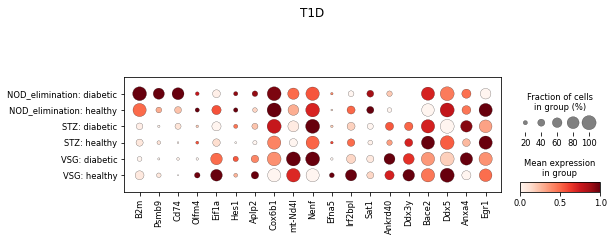

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'group' as categorical


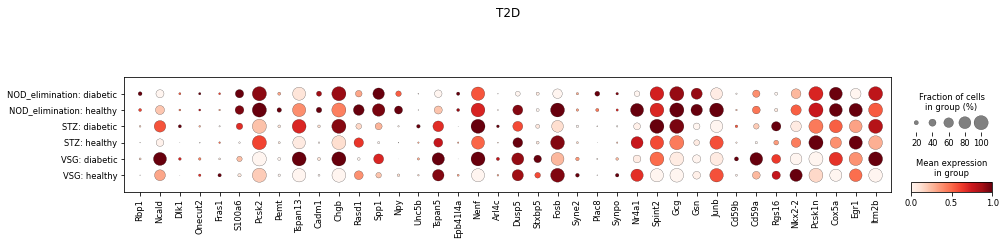

In [314]:
# Plot on mouse
for group, genes in plot_genes.items():
    genes=adata_rn_b.var.loc[genes,'gene_symbol'].values
    sc.pl.dotplot(adata_rn_b[~adata_rn_b.obs.group.isna(),:],var_names=genes,
                  gene_symbols='gene_symbol',use_raw=False,
                  groupby='group',standard_scale='var',title=group)

C: It seems that human diabetes genes do not directly translate to mouse. Not sure if due to mouse-human differences or different metadata of samples (e.g. age, ...). But those genes that show difference between helathy and diseased seem to be in the right direction.

### Gene set comparison
Compare on level of gene sets instead - may be more robust as not looking at individual genes.

Enrichment of human consietnet DE genes for gene sets - then use gene sets to score in mouse. We also added manually currated gene sets from literature.

#### Human DE enrichment
Gene set enrichment of genes consistently DE in human

MSIGdb version: ['v7.4.1']
N gene sets: 11285
CL T1D N genes 32
N enriched gene sets: 198
Top enriched gene sets


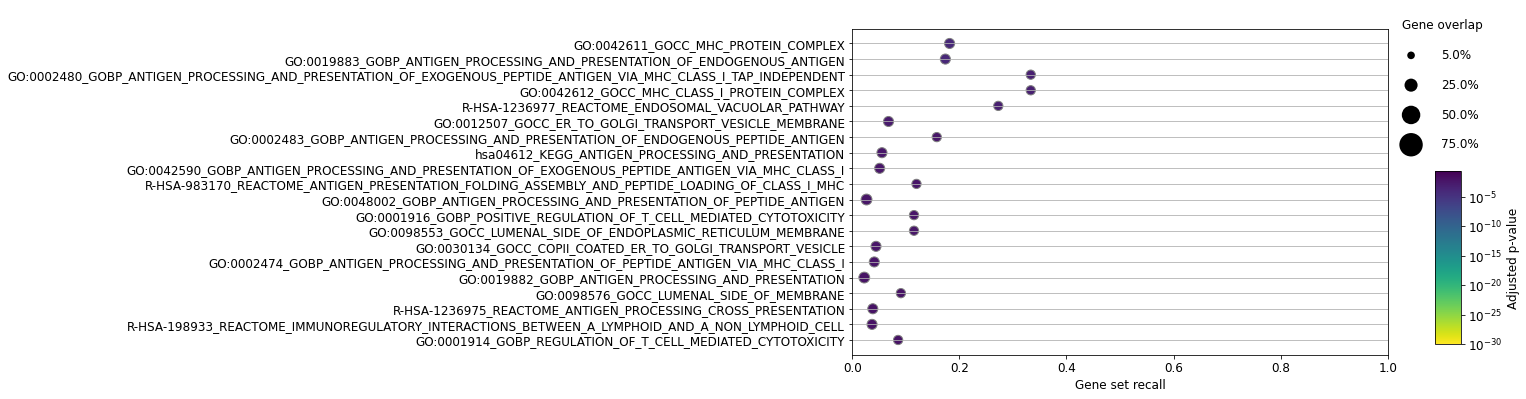

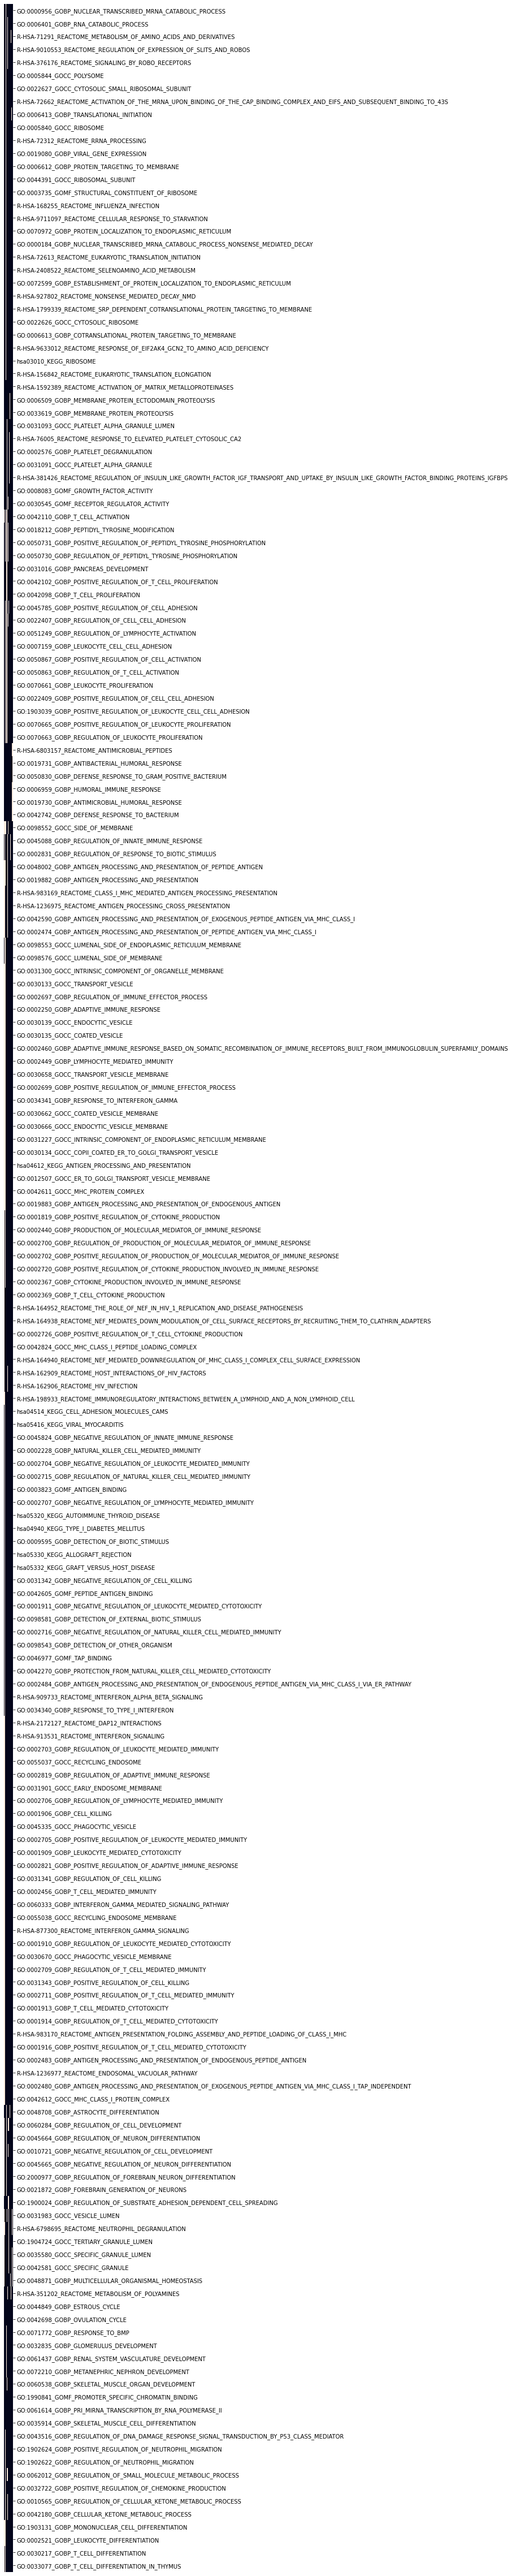

MSIGdb version: ['v7.4.1']
N gene sets: 11339
CL T2D N genes 59
N enriched gene sets: 130
Top enriched gene sets


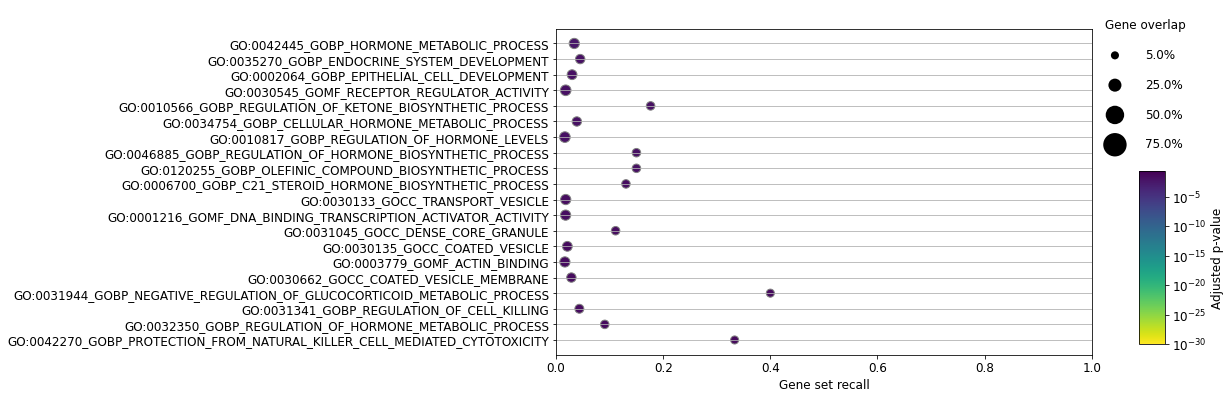

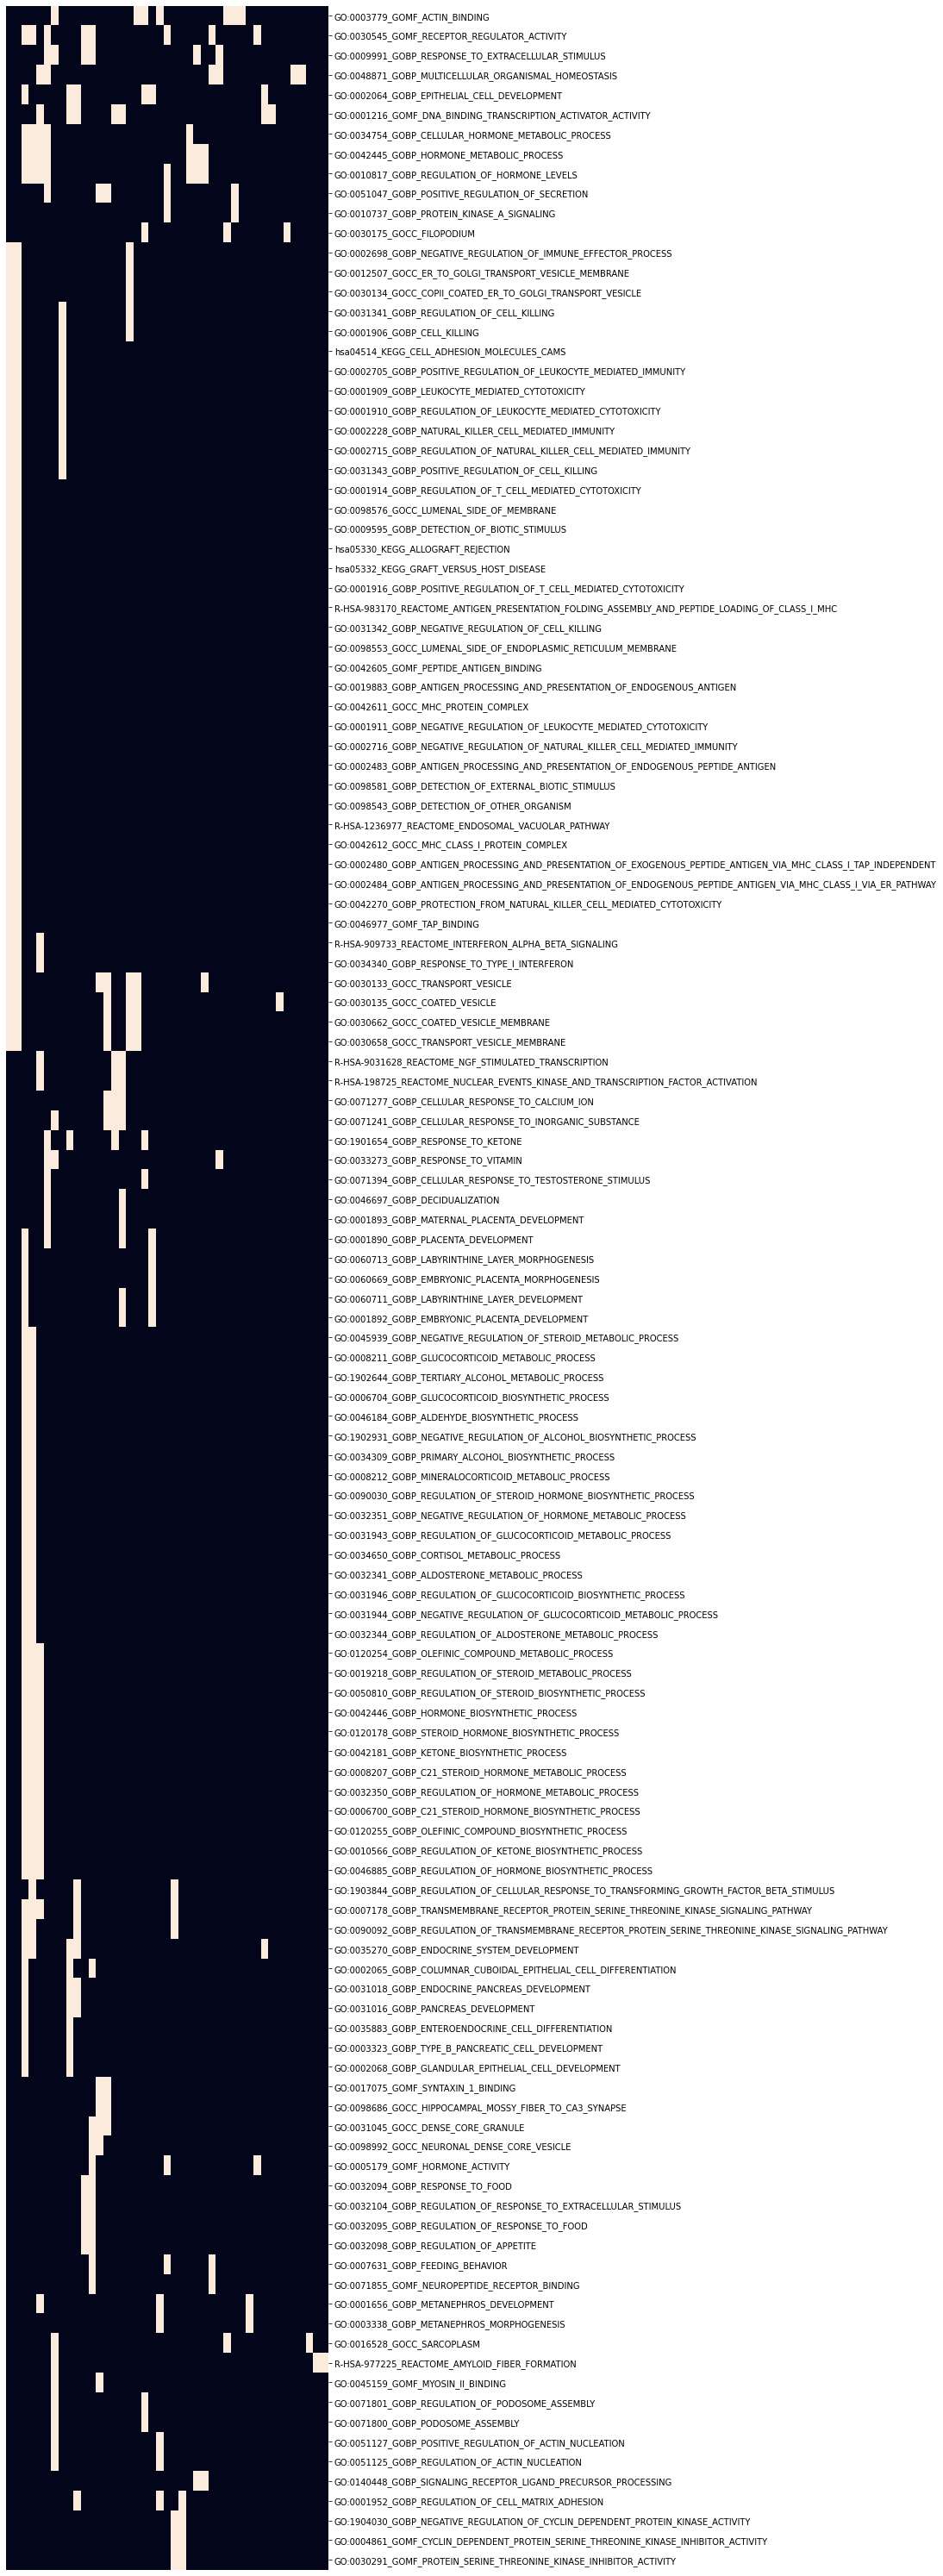

In [452]:
# Compute enrichment in human
enr_data={}
for group in ['T1D','T2D']:
    # Ref genes - must be separate for T1D and T2D
    ref=list(de_results[group].gene_symbol.unique())
    ro.globalenv['ref']=ref

    # Get gene sets
    print('MSIGdb version:',ro.r(f'msigdb_version()'))
    gene_sets_go=ro.r(f"msigdb_gsets_custom(species='Homo sapiens',category='C5',subcategories=c('GO:BP','GO:CC','GO:MF'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
    gene_sets_kegg=ro.r(f"msigdb_gsets_custom(species='Homo sapiens',category='C2',subcategories=c('KEGG'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
    gene_sets_reactome=ro.r(f"msigdb_gsets_custom(species='Homo sapiens',category='C2',subcategories=c('REACTOME'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
    %R -i gene_sets_go -i gene_sets_kegg -i gene_sets_reactome -o gene_sets gene_sets=c(gene_sets_go,gene_sets_kegg,gene_sets_reactome)
    print('N gene sets:',len(gene_sets))
    ro.globalenv['gene_sets']=gene_sets
    
    enrich_fdr=0.25
    ro.globalenv['gs_fdr']=enrich_fdr
    
    data=pd.DataFrame({'n_datasets':de_results[group].query('padj<0.25 & logFC>0.5').groupby('gene_symbol').size(),
     'm_lFC':de_results[group].groupby('gene_symbol')['logFC'].mean(),
     'm_ratio_group' :  de_results[group].groupby('gene_symbol')['ratio_group'].mean()}
                )
    # Filter by N datasets
    min_datasets=de_results[group]['dataset'].nunique()/2.0
    genes=list(data.query('n_datasets>=@min_datasets').index)
    print('CL %s N genes %i'%(group,len(genes)))

    # Calculate enrichment
    ro.globalenv['genes']=genes
    res=ro.r(f'hypeR(signature=as.vector(unlist(genes)),genesets=gene_sets,test = "hypergeometric",background =  as.vector(unlist(ref)),pval = 1,fdr = gs_fdr,plotting = FALSE,quiet = TRUE)')
    ro.globalenv['res']=res
    data=ro.r(f'res$data')
    print('N enriched gene sets:',data.shape[0])
    enr_data[group]=data

    if data.shape[0]>0:
        # Plot top enriched gene sets
        print('Top enriched gene sets')
        data['recall']=data['overlap']/data['geneset']
        data['query_size']=len(genes)
        h.plot_enrich(data=data.rename(
            {'label':'name','fdr':'p_value','overlap':'intersection_size'},axis=1),
            n_terms=20, save=False,min_pval=10**-30, max_pval=enrich_fdr,percent_size=True,
               recall_lim=(0,1))
        h.plot_enr_heatmap(data=data,n_gs=None,xticklabels=False,yticklabels=True)

In [736]:
# Save enrichment tables
writer = pd.ExcelWriter(path_de+'human_overlap_enrichment.xlsx',
                        engine='xlsxwriter') 
for sheet,data in enr_data.items():
    data.to_excel(writer, sheet_name=str(sheet))   
writer.save()

#### Select gene sets
Manually select relevant gene sets from enrichment results and literature

Extract gene sets without "background" filtering for scoring in mouse data to have full gene sets.

In [15]:
# Gene sets without ref as only for scoring
gene_sets_go=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C5',subcategories=c('GO:BP','GO:CC','GO:MF'),size_range=c(5,500),filter_gene_sets=NULL,background=NULL)")
gene_sets_go_dict=dict(gene_sets_go.items())

Gene sets mentioned in other papers:

T2D

Fang 2019
- ATP mt production, oxidative phosphorylation (also Segerstolpe 2016)
- ribosome
- hormone
- glycolysis
- hypoxia
- proteasome
- ER phagosome

Wang 2016
- dedif

Camunas Soler 2020
- compensatory

T1D

Camunas Soler 2020
- immune
- endosomal vacuolar
- ER phagosome

Gene sets to analyse in mouse - containing both gene sets from our DE analysis as well as manually currated gene sets from other papers

In [609]:
gene_sets=[
    # Selected enriched gene sets (based on human genes DE in multiple datasets)
    # Some gene sets are shared in T1D and T2D, 
    # but based on other gene sets that share "hit" genes
    # it can be assumed what is the real reason for enrichment
    
    # T1D
    'GO:0042612_GOCC_MHC_CLASS_I_PROTEIN_COMPLEX',
    'GO:0035580_GOCC_SPECIFIC_GRANULE_LUMEN',
    'GO:0019730_GOBP_ANTIMICROBIAL_HUMORAL_RESPONSE',
    
    # T2D
    'GO:0032104_GOBP_REGULATION_OF_RESPONSE_TO_EXTRACELLULAR_STIMULUS',
    'GO:0030658_GOCC_TRANSPORT_VESICLE_MEMBRANE',
    'GO:0031018_GOBP_ENDOCRINE_PANCREAS_DEVELOPMENT',
    'GO:0042445_GOBP_HORMONE_METABOLIC_PROCESS',
    
    # External - from papers
    # T1D
    'GO:0098927_GOBP_VESICLE_MEDIATED_TRANSPORT_BETWEEN_ENDOSOMAL_COMPARTMENTS',
    
    #T2D
    'GO:0042776_GOBP_MITOCHONDRIAL_ATP_SYNTHESIS_COUPLED_PROTON_TRANSPORT',
    'GO:0006119_GOBP_OXIDATIVE_PHOSPHORYLATION',
    'GO:0042254_GOBP_RIBOSOME_BIOGENESIS',
    'GO:0006007_GOBP_GLUCOSE_CATABOLIC_PROCESS',
    'GO:1900037_GOBP_REGULATION_OF_CELLULAR_RESPONSE_TO_HYPOXIA',
    'GO:0010498_GOBP_PROTEASOMAL_PROTEIN_CATABOLIC_PROCESS'
]

Plot selected gene sets gene overlaps (given as overlap/len_smaller_gs)

In [610]:
# Overlap as ratio of smaller gene set
overlaps=pd.DataFrame(index=gene_sets,columns=gene_sets)
for i in range(len(gene_sets)-1):
    for j in range(i+1,len(gene_sets)):
        gi=gene_sets[i]
        genesi=set(gene_sets_go_dict[gi])
        gj=gene_sets[j]
        genesj=set(gene_sets_go_dict[gj])
        o=len(genesi&genesj)/min([len(genesi),len(genesj)])
        overlaps.at[gi,gj]=o
        overlaps.at[gj,gi]=o
overlaps=overlaps.fillna(1)

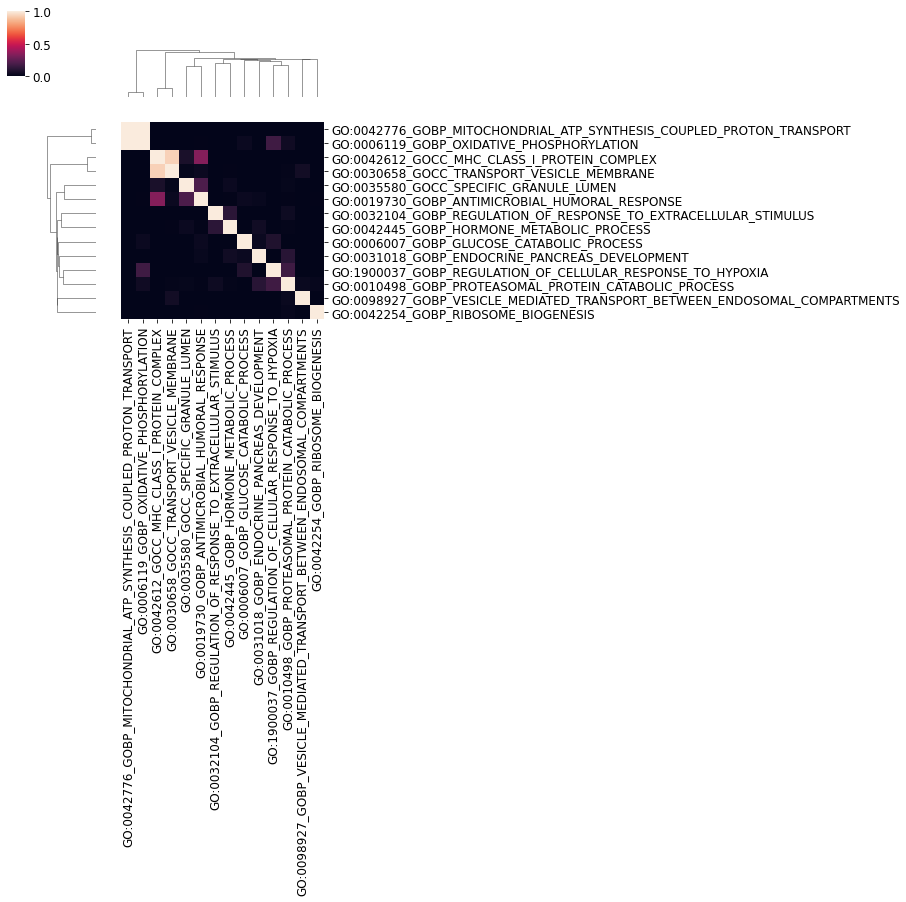

In [613]:
# plot overlap
sb.clustermap(overlaps,figsize=(5,5),
             xticklabels=True,yticklabels=True)

In [614]:
# N genes per gene set
for gs in gene_sets:
    print(gs,len(gene_sets_go_dict[gs]))

GO:0042612_GOCC_MHC_CLASS_I_PROTEIN_COMPLEX 40
GO:0035580_GOCC_SPECIFIC_GRANULE_LUMEN 65
GO:0019730_GOBP_ANTIMICROBIAL_HUMORAL_RESPONSE 213
GO:0032104_GOBP_REGULATION_OF_RESPONSE_TO_EXTRACELLULAR_STIMULUS 26
GO:0030658_GOCC_TRANSPORT_VESICLE_MEMBRANE 231
GO:0031018_GOBP_ENDOCRINE_PANCREAS_DEVELOPMENT 46
GO:0042445_GOBP_HORMONE_METABOLIC_PROCESS 235
GO:0098927_GOBP_VESICLE_MEDIATED_TRANSPORT_BETWEEN_ENDOSOMAL_COMPARTMENTS 42
GO:0042776_GOBP_MITOCHONDRIAL_ATP_SYNTHESIS_COUPLED_PROTON_TRANSPORT 22
GO:0006119_GOBP_OXIDATIVE_PHOSPHORYLATION 146
GO:0042254_GOBP_RIBOSOME_BIOGENESIS 300
GO:0006007_GOBP_GLUCOSE_CATABOLIC_PROCESS 35
GO:1900037_GOBP_REGULATION_OF_CELLULAR_RESPONSE_TO_HYPOXIA 12
GO:0010498_GOBP_PROTEASOMAL_PROTEIN_CATABOLIC_PROCESS 480


C: A few gene sets could potentially be dropped as they have a large overlap with anotehr gene sets.

#### Expression of gene sets in mouse

Prepare mouse data for plotting - add cell groups

In [11]:
# Subset data for scoring
adata_rn_b_sub=adata_rn_b[~adata_rn_b.obs.group.isna(),:].copy()

In [12]:
# Add healthy/diseased info for plot
adata_rn_b_sub.obs['status']=adata_rn_b_sub.obs['group'].apply(lambda x: x.split(': ')[1])
adata_rn_b_sub.obs['model']=adata_rn_b_sub.obs['group'].apply(lambda x: x.split(': ')[0])

Score mouse data for gene sets

In [714]:
# Compute scores
# First remove pre-computed scores
adata_rn_b_sub.obs.drop([c for c in adata_rn_b_sub.obs.columns 
                         if 'score_gs_' in c],axis=1,inplace=True)
for gs in gene_sets:
    sc.tl.score_genes(adata_rn_b_sub,
                      adata_rn_b_sub.var_names[adata_rn_b_sub.var.gene_symbol.isin(
                          gene_sets_go_dict[gs])],
                      score_name='score_gs_'+gs )
    
    # Alternative score computation - compute PC1 on genes and direct based on correlation
    # of mean expression of genes in each cell (as PCA not directed)
    # Dont use this as may increase batch effect - the orther score computed per cell, 
    # but this one tries to capture maximal var which could also be batch 
    # (could sometimes see much stronger differences between models even on healthy)
    # CHANGED - compute per dataset and then scale to 0,1 per dataset 
    # to make comparable across datasets
    # UNUSED - most scores were more distinct, but one looked odd - decided not to use 
    # as could be too affected by weights of individual genes - the genes
    # would be differently weighted across datasets
    
    #genes=gene_sets_go_dict[gs]
    #genes=adata_rn_b_sub.var.query('gene_symbol in @genes').index
    #for model in adata_rn_b_sub.obs['model'].unique():
    #    adata_temp=adata_rn_b_sub[adata_rn_b_sub.obs.model==model,genes]
    #    score=sc.pp.pca(data=adata_temp.to_df().values,n_comps=1)[:,0].ravel()
    #    score=score*np.corrcoef(
    #        score,adata_temp.to_df().values.mean(axis=1))[0,1]
    #    adata_rn_b_sub.obs.loc[adata_temp.obs_names,'score_gs_'+gs]=minmax_scale(score)

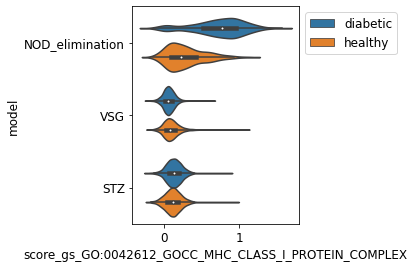

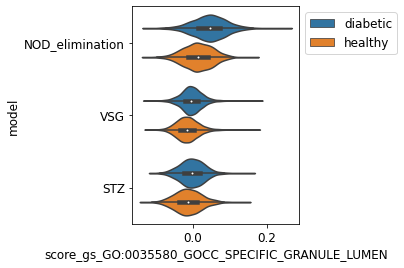

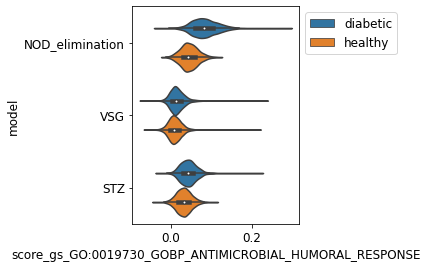

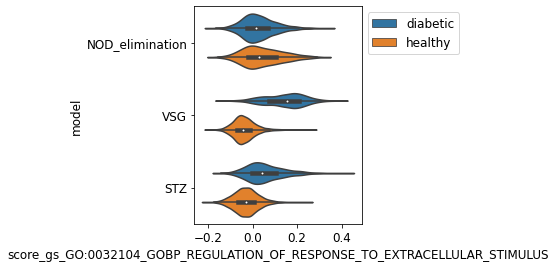

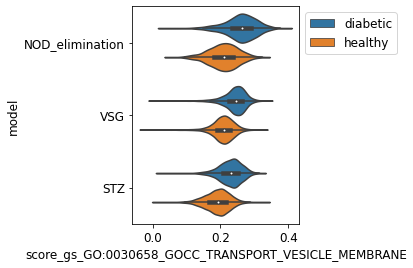

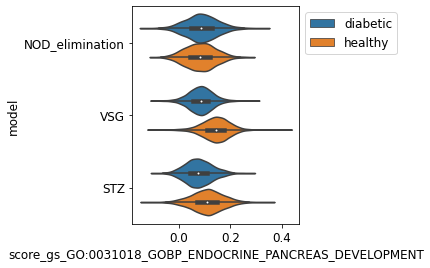

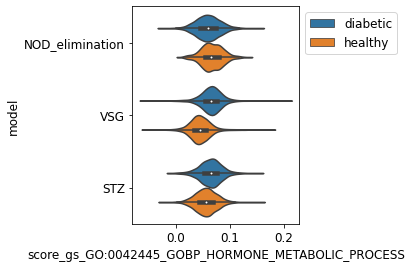

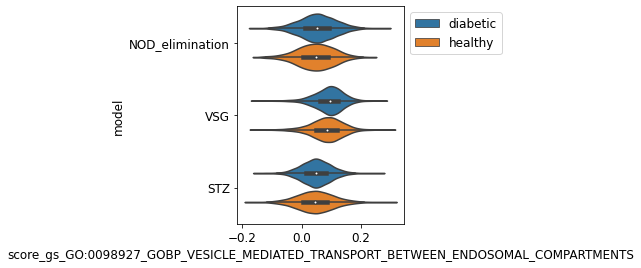

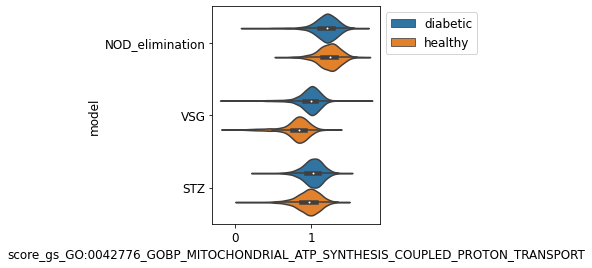

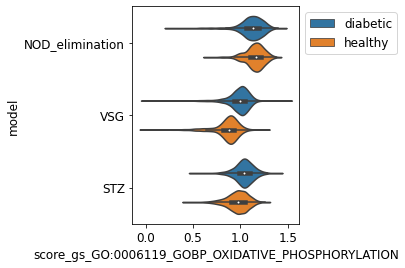

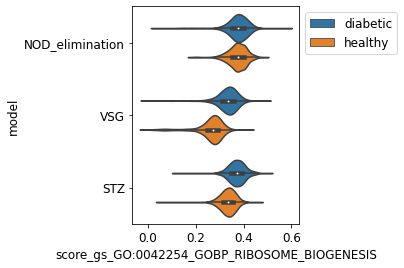

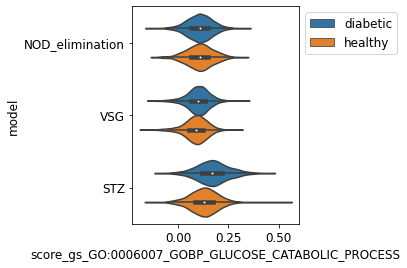

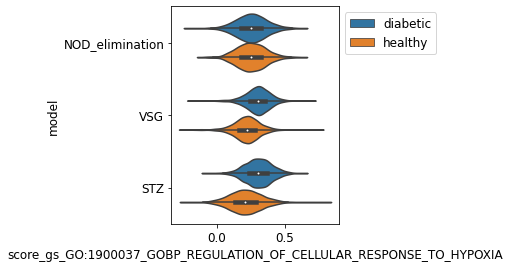

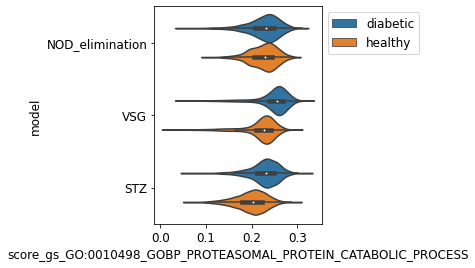

In [616]:
# Plot distn (no significance)
for gs in gene_sets:
    fig,ax=plt.subplots(figsize=(3,4))
    g=sb.violinplot(y='model',x='score_gs_'+gs,data=adata_rn_b_sub.obs,hue='status')
    plt.legend(bbox_to_anchor=(1,1))

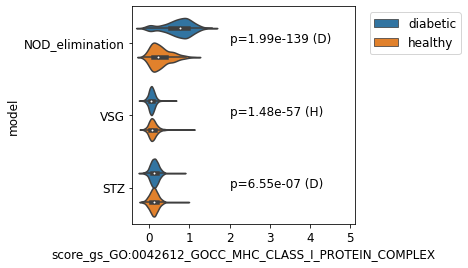

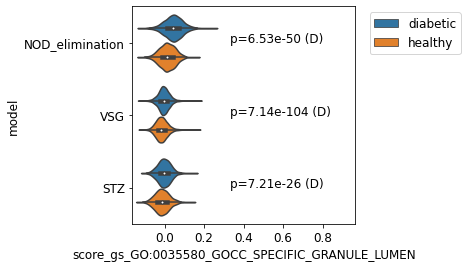

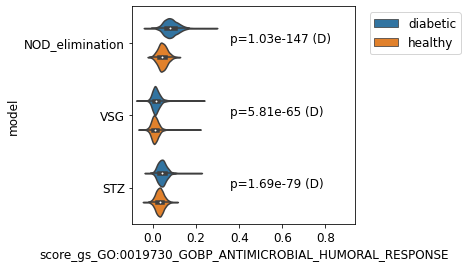

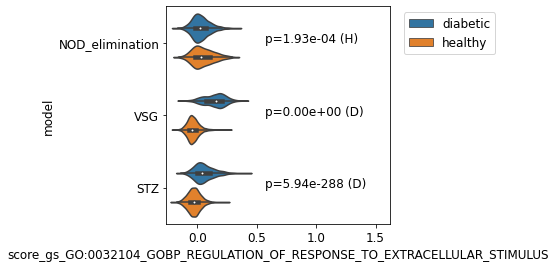

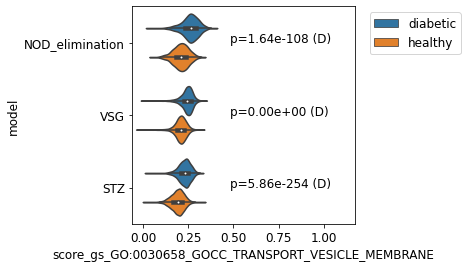

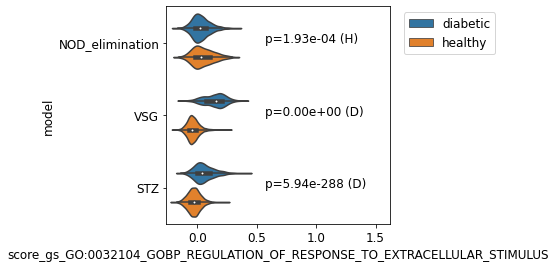

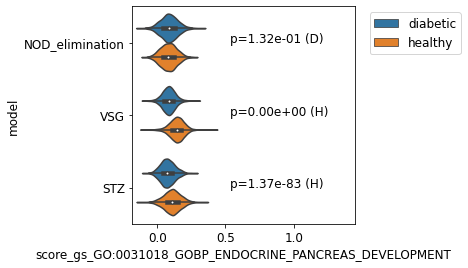

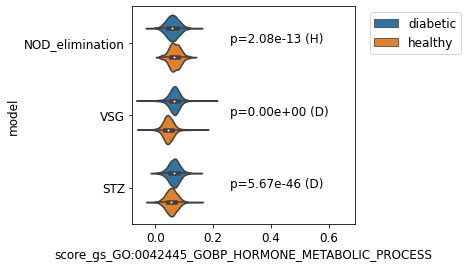

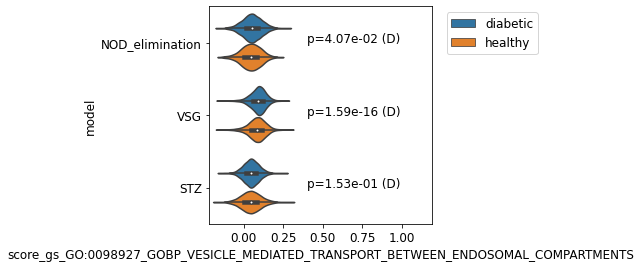

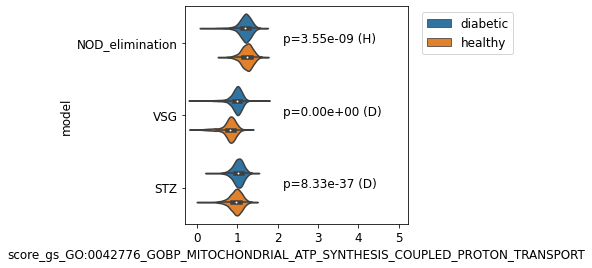

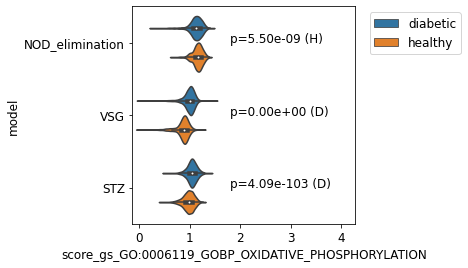

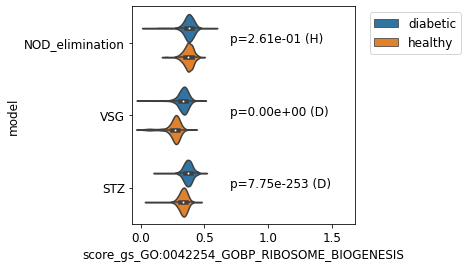

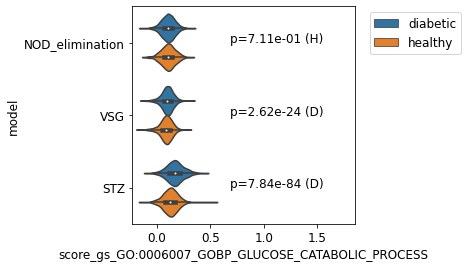

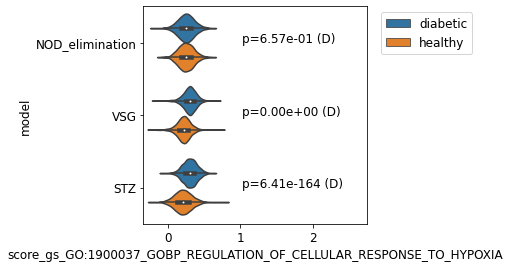

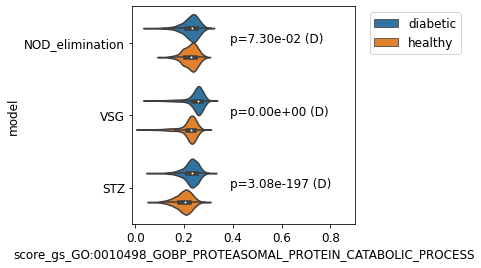

In [605]:
# Plot distn with significance between healthy;/diab per model
for gs in gene_sets:
    fig,ax=plt.subplots(figsize=(4,4))
    g=sb.violinplot(y='model',x='score_gs_'+gs,data=adata_rn_b_sub.obs,hue='status')
    labels=[t.get_text() for t in ax.get_yticklabels()]
    for model in adata_rn_b_sub.obs.model.unique():
        g1=model+': diabetic'
        g2=model+': healthy'
        p=mannwhitneyu(adata_rn_b_sub.obs.query('group==@g1')['score_gs_'+gs],
                     adata_rn_b_sub.obs.query('group==@g2')['score_gs_'+gs])[1]
        g='D' if  adata_rn_b_sub.obs.query('group==@g1')['score_gs_'+gs].mean()>\
            adata_rn_b_sub.obs.query('group==@g2')['score_gs_'+gs].mean() else 'H'
        ax.annotate('p='+"{:.2e}".format(p)+' ('+g+')', 
                    xy=(ax.get_xlim()[1]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.1,
                        np.argwhere(np.array(labels)==model)[0][0]), 
                    zorder=10)
    ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1]+(ax.get_xlim()[1]-ax.get_xlim()[0])*1.5)
    plt.legend(bbox_to_anchor=(1.5,1))

Selection of gene sets that are informative, plot for paper

In [13]:
gene_sets_sub=[
    'GO:0042612_GOCC_MHC_CLASS_I_PROTEIN_COMPLEX',
    'GO:0019730_GOBP_ANTIMICROBIAL_HUMORAL_RESPONSE',
    'GO:0032104_GOBP_REGULATION_OF_RESPONSE_TO_EXTRACELLULAR_STIMULUS',
    'GO:0030658_GOCC_TRANSPORT_VESICLE_MEMBRANE',
    'GO:0031018_GOBP_ENDOCRINE_PANCREAS_DEVELOPMENT',
    'GO:0042445_GOBP_HORMONE_METABOLIC_PROCESS',
    'GO:0006119_GOBP_OXIDATIVE_PHOSPHORYLATION',
    'GO:0042254_GOBP_RIBOSOME_BIOGENESIS',
    'GO:1900037_GOBP_REGULATION_OF_CELLULAR_RESPONSE_TO_HYPOXIA',
    'GO:0010498_GOBP_PROTEASOMAL_PROTEIN_CATABOLIC_PROCESS'
]

In [17]:
# Data for plotting
model_map={'NOD_elimination':'NOD','VSG':'db/db','STZ':'mSTZ'}
data=[]
gs_map={}
for gs in gene_sets_sub:
    d=adata_rn_b_sub.obs[['score_gs_'+gs,'model','status']].copy()
    d.rename({'score_gs_'+gs:'score'},axis=1,inplace=True)
    gs_name=' '.join(gs.split('_')[2:])
    d['gene_set']=gs_name
    gs_map[gs_name]=gs
    d['model']=d['model'].map(model_map)
    data.append(d)
data=pd.concat(data)

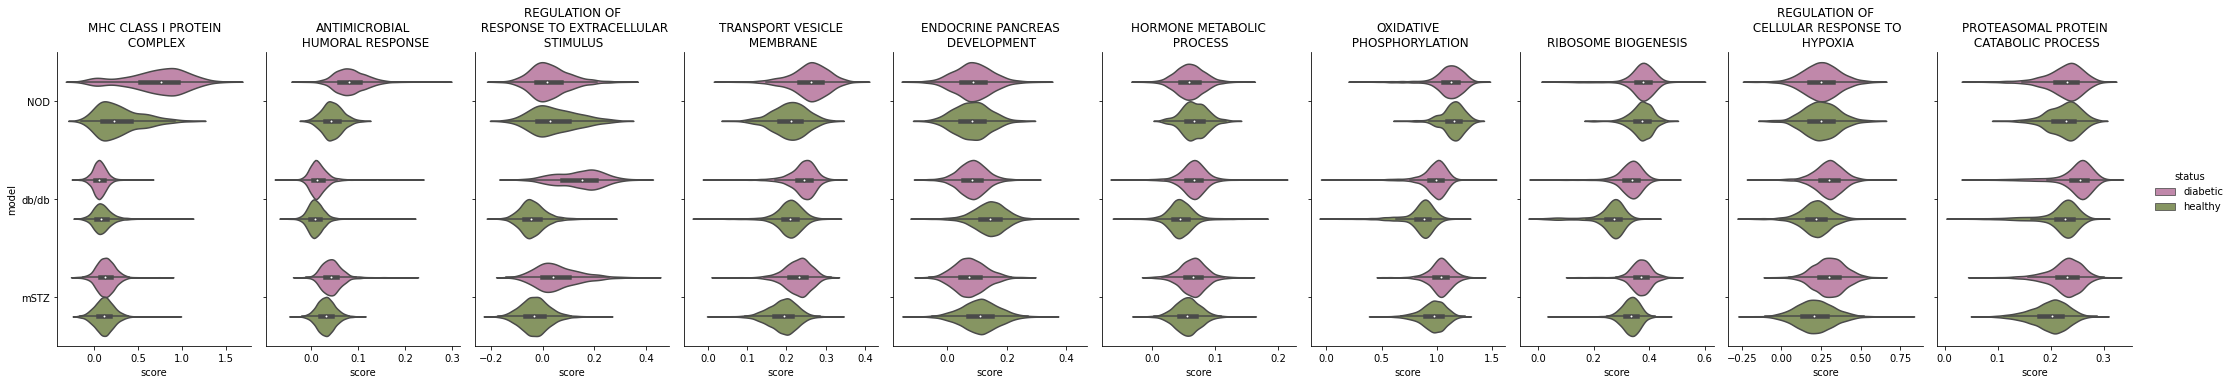

In [18]:
# Plot gene set scores across models
g=sb.catplot(y='model',x='score',col='gene_set',hue='status',data=data,kind='violin',
           sharex=False,aspect=.6,palette={'healthy':'#8a9e59','diabetic':'#c97fac'})
ylabels=[l.get_text() for l in g.axes[0][0].get_yticklabels()]
for ax in g.axes[0]:
    t=ax.get_title().replace('gene_set = ','')
    split_at=[0]
    l=20
    i=1
    while len(t)>i*l and ' ' in t[(i-1)*l:]:
        start=(i-1)*l
        end=i*l
        split_at.append((t[start:end].rfind(' ') if ' ' in t[start:end] else 0)+start)
        i+=1
    t_parts=[]
    if len(split_at)>1:
        for i in range(1,len(split_at)):
            t_parts.append(t[split_at[i-1]:split_at[i]])
        t_parts.append(t[split_at[i]:])
    else:
        t_parts=[t]
    ax.set_title('\n'.join(t_parts))   
    
    # Make transparent
    ax.set(facecolor = (0,0,0,0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.savefig(path_fig+'violin_beta_humanDiabeticGS_score.png',dpi=300,bbox_inches='tight')

For each gene set compute pval and lFCs of healthy vs diabetic mice model on per dataset level

In [19]:
# lFCs of scores per model
res=[]
for gs in gene_sets_sub:
    for model in adata_rn_b_sub.obs.model.unique():
        g1=model+': diabetic'
        g2=model+': healthy'
        # minmax scale score for each model as else scores may be negative 
        # producing errors in lFC
        score_model=pd.DataFrame(
            minmax_scale(adata_rn_b_sub.obs.query('model==@model')['score_gs_'+gs]),
            index=adata_rn_b_sub.obs.query('model==@model').index,
            columns=['score'])
        score_model['group']=adata_rn_b_sub.obs.query('model==@model').group
        # lFC of medians
        s1=score_model.query('group==@g1')['score']
        s2=score_model.query('group==@g2')['score']
        me_lfc=np.log( (s1.median())/   (s2.median()))
        # pval
        p=mannwhitneyu(s1,s2)[1]
        res.append({'model':model,'gene_set':gs,'me_logFC':me_lfc,'pval':p})
res=pd.DataFrame(res)
res['model']=res['model'].map(model_map)

In [20]:
# Gene set score DE results
res

,model,gene_set,me_logFC,pval
0,NOD,GO:0042612_GOCC_MHC_CLASS_I_PROTEIN_COMPLEX,0.837413,1.987168e-139
1,db/db,GO:0042612_GOCC_MHC_CLASS_I_PROTEIN_COMPLEX,-0.075227,1.481093e-57
2,mSTZ,GO:0042612_GOCC_MHC_CLASS_I_PROTEIN_COMPLEX,0.044751,6.545152e-07
3,NOD,GO:0019730_GOBP_ANTIMICROBIAL_HUMORAL_RESPONSE,0.418911,1.030383e-147
4,db/db,GO:0019730_GOBP_ANTIMICROBIAL_HUMORAL_RESPONSE,0.053417,5.807052e-65
5,mSTZ,GO:0019730_GOBP_ANTIMICROBIAL_HUMORAL_RESPONSE,0.143032,1.686833e-79
6,NOD,GO:0032104_GOBP_REGULATION_OF_RESPONSE_TO_EXTR...,-0.057049,1.930270e-04
7,db/db,GO:0032104_GOBP_REGULATION_OF_RESPONSE_TO_EXTR...,0.821465,0.000000e+00
8,mSTZ,GO:0032104_GOBP_REGULATION_OF_RESPONSE_TO_EXTR...,0.346937,5.942459e-288
9,NOD,GO:0030658_GOCC_TRANSPORT_VESICLE_MEMBRANE,0.258124,1.635492e-108


In [21]:
# Save gs DE
res.to_csv(path_de+'mouse_models_genesets_lfcDvsH.tsv',index=False,sep='\t')